## Install and Import Library

In [ ]:
!pip install -q mne
!pip install -q statannotations
!pip install -q mne-features

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
%%capture
!unzip /content/drive/MyDrive/eeg_depression_preprocessed.zip -d eeg_depression_preprocessed ##put your preprocessed data path

In [ ]:
import os
import numpy as np
import pandas as pd
import re
pd.reset_option('display.float_format')

import mne
from mne_features.feature_extraction import extract_features

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

from tqdm import tqdm

from tensorflow.keras.utils import to_categorical

from scipy.signal import welch
from scipy.integrate import simps

from statannotations.Annotator import Annotator

np.set_printoptions(suppress=True)

from numpy.random import seed
seed(2023)
from tensorflow.random import set_seed
set_seed(2023)

## Load Data

In [ ]:
fp = '/content/eeg_depression_preprocessed/'

EO = []
for file in os.listdir(fp):
  path = os.path.join(fp,file)
  if 'EO' in path:
    EO.append(path)
healthyEO_fp = sorted([i for i in EO if 'H' in i])
mddEO_fp = sorted([i for i in EO if 'MDD' in i])

EC = []
for file in os.listdir(fp):
  path = os.path.join(fp,file)
  if 'EC' in path:
    EC.append(path)
healthyEC_fp = sorted([i for i in EC if 'H' in i])
mddEC_fp = sorted([i for i in EC if 'MDD' in i])

In [ ]:
def read_data_epoch(fp, duration, overlap=5):
  data = mne.io.read_raw_edf(fp, preload=True)
  time = data.__len__()/256
  data.crop(tmin=30, tmax=160)
  epochs = mne.make_fixed_length_epochs(data, duration=duration, overlap=overlap)
  arr = epochs.get_data()
  return arr

In [ ]:
def get_data_epoch(healthy_fp, mdd_fp, duration, overlap=5):
  healthy_data_epoch = [read_data_epoch(i, duration, overlap) for i in healthy_fp]
  mdd_data_epoch = [read_data_epoch(i, duration, overlap) for i in mdd_fp]

  healthy_label_epoch = [len(i)*[0] for i in healthy_data_epoch]
  mdd_label_epoch = [len(i)*[1] for i in mdd_data_epoch]

  data_epoch = healthy_data_epoch + mdd_data_epoch
  label_epoch = healthy_label_epoch + mdd_label_epoch
  group = [[i]*len(j) for i,j in enumerate(data_epoch)]

  arr_epoch = np.vstack(data_epoch)
  label_arr_epoch = np.hstack(label_epoch)
  group_arr_epoch = np.hstack(group)

  return arr_epoch, label_arr_epoch, group_arr_epoch

In [ ]:
%%capture
EO_arr_epoch, EO_labelarr_epoch, EO_grouparr = get_data_epoch(healthyEO_fp, mddEO_fp, 32, 1)
EC_arr_epoch, EC_labelarr_epoch, EC_grouparr = get_data_epoch(healthyEC_fp, mddEC_fp, 32, 1)
all_arr_epoch = np.vstack([EO_arr_epoch,EC_arr_epoch])
all_labelarr_epoch = np.hstack([EO_labelarr_epoch,EC_labelarr_epoch])
all_grouparr = np.hstack([EC_grouparr, EO_grouparr+EC_grouparr[-1]])

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

def prep_data(data, label, group, seed=0, train_size=0.8, val_size=0.1, test_size=0.1, norm=True, categorical=False):
  train_size_ = train_size/(1-test_size)
  gss1 = GroupShuffleSplit(n_splits=1, train_size=train_size+val_size, random_state=seed)
  gss2 = GroupShuffleSplit(n_splits=1, train_size=train_size_, random_state=seed+1)

  for i, (dev_index, test_index) in enumerate(gss1.split(data, label, group)):
    X_dev = data[dev_index]
    X_test = data[test_index]
    y_dev = label[dev_index]
    y_test = label[test_index]
    group_dev = group[dev_index]
    group_test = group[test_index]

    for i, (train_index, val_index) in enumerate(gss2.split(X_dev, y_dev, group_dev)):
      X_train = X_dev[train_index]
      X_val = X_dev[val_index]
      y_train = y_dev[train_index]
      y_val = y_dev[val_index]
      group_train = group_dev[train_index]
      group_val = group_dev[val_index]

  if categorical ==True:
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)

  if norm==True:
    X_train_norm = []
    X_val_norm = []
    X_test_norm = []

    for i in range(X_train.shape[0]):
        X_train_norm.append(np.expand_dims((X_train[i] - np.mean(X_train[i], keepdims=True)) / np.std(X_train[i], keepdims=True), axis=0))

    for i in range(X_val.shape[0]):
        X_val_norm.append(np.expand_dims((X_val[i] - np.mean(X_val[i], keepdims=True)) / np.std(X_val[i], keepdims=True), axis=0))

    for i in range(X_test.shape[0]):
        X_test_norm.append(np.expand_dims((X_test[i] - np.mean(X_test[i], keepdims=True)) / np.std(X_test[i], keepdims=True), axis=0))

    X_train_norm=np.vstack(X_train_norm)
    X_val_norm=np.vstack(X_val_norm)
    X_test_norm=np.vstack(X_test_norm)

    return X_train_norm, X_val_norm, X_test_norm, y_train, y_val, y_test

  elif norm==False:
    return X_train, X_val, X_test, y_train, y_val, y_test

## Linear Features (Spectral features)

I have extracted 4 relative band power i.e. delta power, theta power, alpha power, and beta power

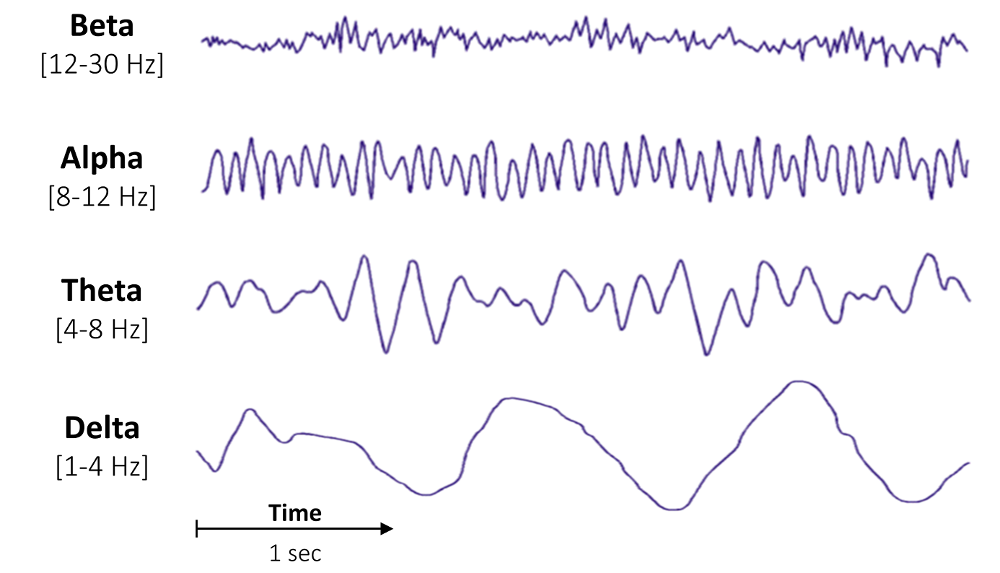

In [ ]:
def bandpower(data, band, sf=256, window_sec=None, relative=True):
  band = np.asarray(band)
  low, high = band

  # Define window length
  if window_sec is not None:
      nperseg = window_sec * sf
  else:
      nperseg = (2 / low) * sf

  # Compute the modified periodogram (Welch)
  freqs, psd = welch(data, sf, nperseg=nperseg)

  # Frequency resolution
  freq_res = freqs[1] - freqs[0]

  # Find closest indices of band in frequency vector
  idx_band = np.logical_and(freqs >= low, freqs <= high)

  # Integral approximation of the spectrum using Simpson's rule.
  bp = simps(psd[idx_band], dx=freq_res)

  if relative:
      bp /= simps(psd, dx=freq_res)
  return bp

In [ ]:
sf=256.
win_sec=4

delta_f = [0.5, 4]
theta_f = [4, 8]
alpha_f = [8, 12]
beta_f = [12, 30]

n_ch = 19
channels = ['Fp1','F3','C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Fz', 'Cz', 'Pz']

In [ ]:
def get_band_power_arr(data, bands=[[0.5, 4], [4, 8], [8, 12], [12, 30]]):
  n_ch = data.shape[1]
  band_power_arr = np.zeros((data.shape[0], n_ch, len(bands)))
  for i in range(data.shape[0]):
    for ch in range(n_ch):
      for j, band in enumerate(bands):
        band_power_arr[i,ch,j] = bandpower(data[i,ch], band)
  return band_power_arr

In [ ]:
def get_band_power_df(data, label, channels, bands = ['delta', 'theta', 'alpha', 'beta', 'gamma'], sf=256, relative=True):
  df = pd.DataFrame(columns=['group', 'channel']+bands)
  band_dict = {'delta':[0.5, 4], 'theta':[4, 8], 'alpha':[8, 12], 'beta':[12, 30], 'gamma':[30, 45]}
  i=0
  for n in range(data.shape[0]):
    if label[n] == 0:
      group='Healthy'
    else:
      group='MDD'
    for ch_id, ch_name in enumerate(channels):
      channel = ch_name
      bandps=[]
      for band in bands:
        bandps.append(bandpower(data[n,ch_id], band_dict[band], sf, relative=relative))
      df.loc[i] = [group, channel]+bandps
      i+=1
  return df

In [ ]:
EC_band_power_rel = get_band_power_df(EC_arr_epoch, EC_labelarr_epoch, channels)
EO_band_power_rel = get_band_power_df(EO_arr_epoch, EO_labelarr_epoch, channels)

EC_band_power_rel.to_csv("/content/drive/MyDrive/eeg_depression/EC_band_power.csv")
EO_band_power_rel.to_csv("/content/drive/MyDrive/eeg_depression/EO_band_power.csv")

### Plot

In [ ]:
url = f"https://raw.githubusercontent.com/trevismd/statannotations-tutorials/main/Tutorial_1/utils.py"
!wget --no-cache --backups=1 {url}

--2023-03-29 14:51:57--  https://raw.githubusercontent.com/trevismd/statannotations-tutorials/main/Tutorial_1/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2114 (2.1K) [text/plain]
Failed to rename utils.py to utils.py.1: (2) No such file or directory
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.06K  --.-KB/s    in 0s      

2023-03-29 14:51:57 (27.1 MB/s) - ‘utils.py’ saved [2114/2114]



In [ ]:
pairs = [[(ch, 'Healthy'), (ch, 'MDD')] for ch in channels]

In [ ]:
EC_band_power = pd.read_csv("/content/drive/MyDrive/eeg_depression/EC_band_power.csv", index_col=0)
EO_band_power = pd.read_csv("/content/drive/MyDrive/eeg_depression/EO_band_power.csv", index_col=0)

In [ ]:
from scipy import stats

bands = ['delta', 'theta', 'alpha', 'beta']
df_ttest = pd.DataFrame(index=channels, columns=bands)
for ch in channels:
  for band in bands:
    h_power = EO_band_power[[(EO_band_power.loc[i,'group']=='Healthy') and (EO_band_power.loc[i,'channel']==ch) for i in range(EO_band_power.shape[0])]][band].values
    mdd_power = EO_band_power[[(EO_band_power.loc[i,'group']=='MDD') and (EO_band_power.loc[i,'channel']==ch) for i in range(EO_band_power.shape[0])]][band].values
    stat, p = stats.ttest_ind(h_power, mdd_power)
    df_ttest.loc[ch, band] = p

#### EC plot

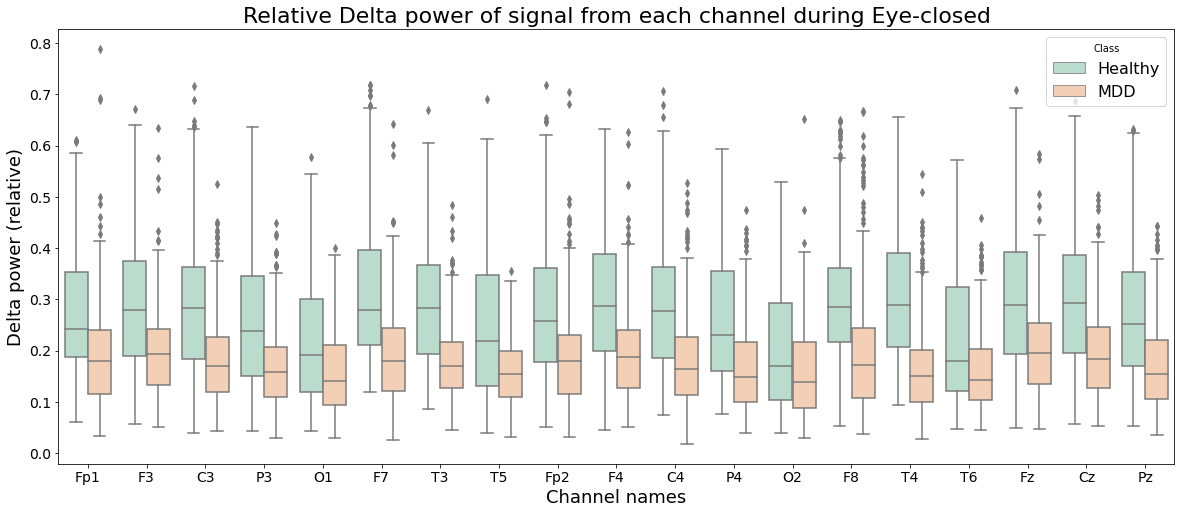

In [ ]:
hue_plot_params = {
    'data': EC_band_power_rel,
    'x': 'channel',
    'y': 'delta',
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Delta power (relative)', fontsize=18);
plt.title('Relative Delta power of signal from each channel during Eye-closed', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)

fig.savefig('/content/drive/MyDrive/eeg_depression/results/delta_EC_nostats.jpg')
plt.show()

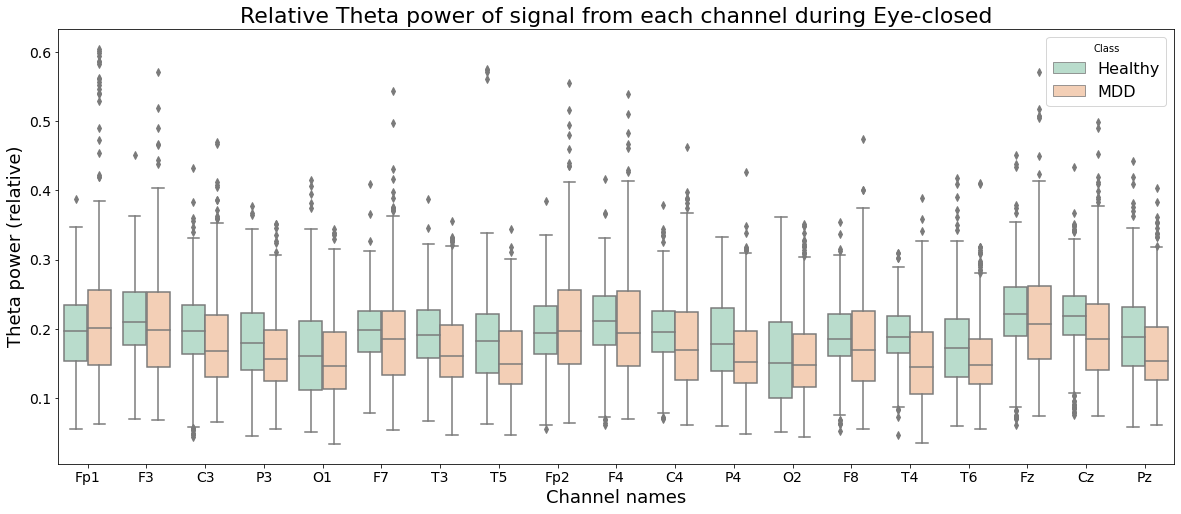

In [ ]:
hue_plot_params = {
    'data': EC_band_power_rel,
    'x': 'channel',
    'y': 'theta',
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Theta power (relative)', fontsize=18);
plt.title('Relative Theta power of signal from each channel during Eye-closed', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('/content/drive/MyDrive/eeg_depression/results/theta_EC_nostats.jpg')
plt.show()

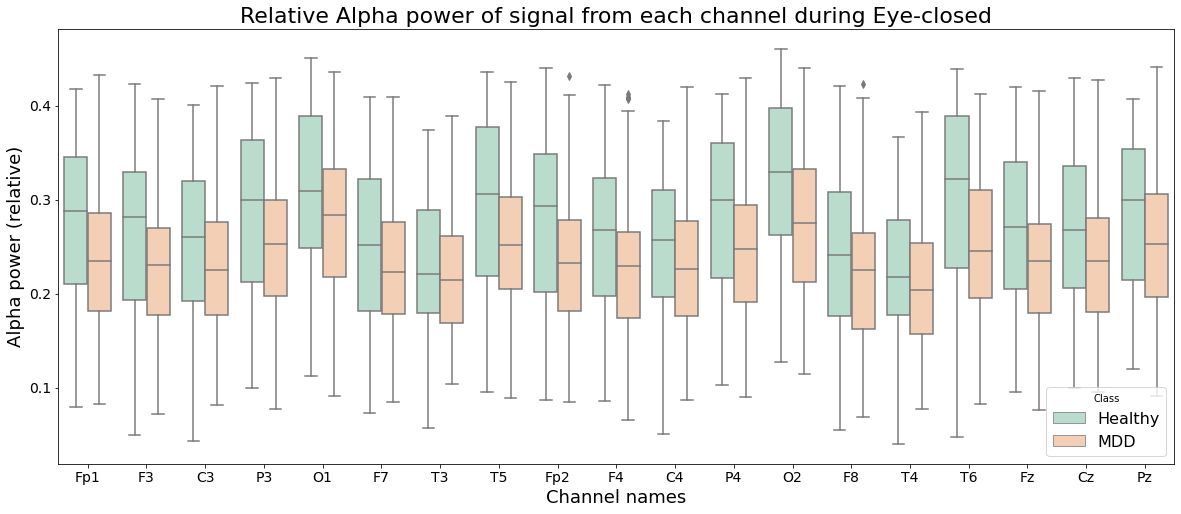

In [ ]:
hue_plot_params = {
    'data': EC_band_power_rel,
    'x': 'channel',
    'y': 'alpha',
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Alpha power (relative)', fontsize=18);
plt.title('Relative Alpha power of signal from each channel during Eye-closed', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('/content/drive/MyDrive/eeg_depression/results/alpha_EC_nostats.jpg')
plt.show()

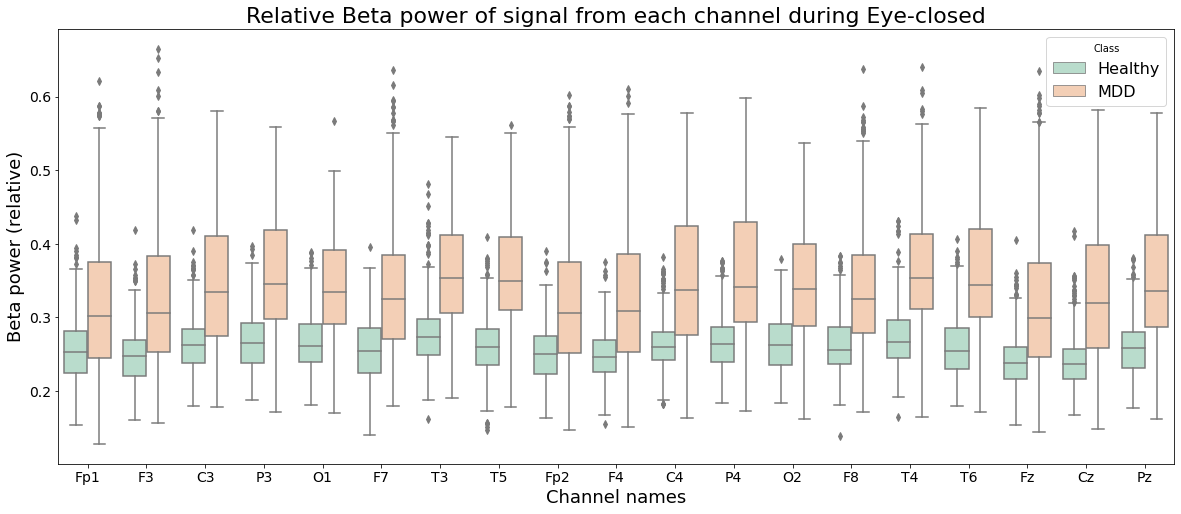

In [ ]:
hue_plot_params = {
    'data': EC_band_power_rel,
    'x': 'channel',
    'y': 'beta',
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Beta power (relative)', fontsize=18);
plt.title('Relative Beta power of signal from each channel during Eye-closed', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('/content/drive/MyDrive/eeg_depression/results/beta_EC_nostats.jpg')
plt.show()

#### EO plot

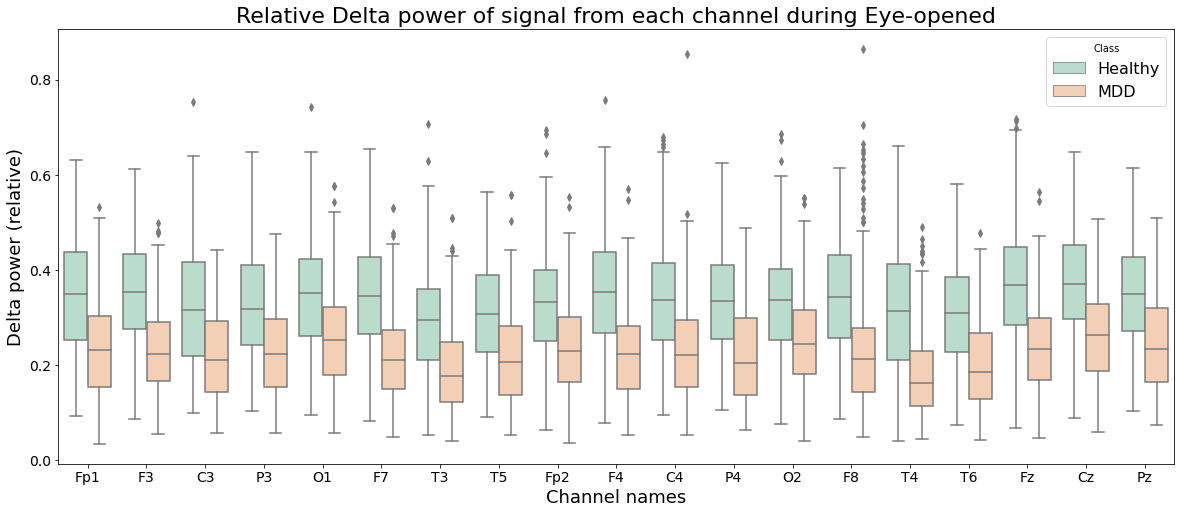

In [ ]:
hue_plot_params = {
    'data': EO_band_power_rel,
    'x': 'channel',
    'y': 'delta',
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Delta power (relative)', fontsize=18);
plt.title('Relative Delta power of signal from each channel during Eye-opened', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('/content/drive/MyDrive/eeg_depression/results/delta_EO_nostats.jpg')
plt.show()

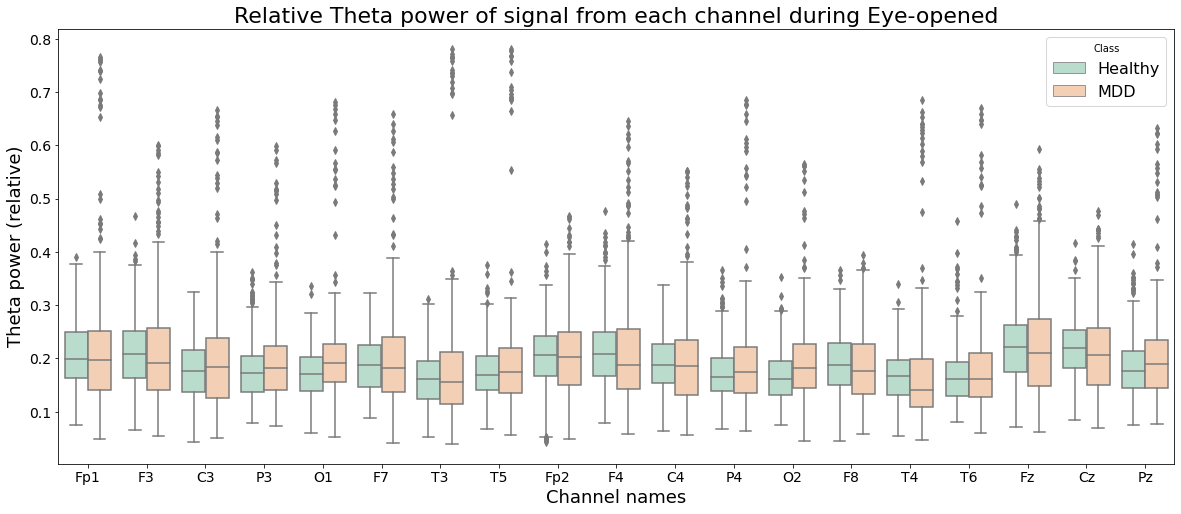

In [ ]:
hue_plot_params = {
    'data': EO_band_power_rel,
    'x': 'channel',
    'y': 'theta',
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Theta power (relative)', fontsize=18);
plt.title('Relative Theta power of signal from each channel during Eye-opened', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('/content/drive/MyDrive/eeg_depression/results/theta_EO_nostats.jpg')
plt.show()

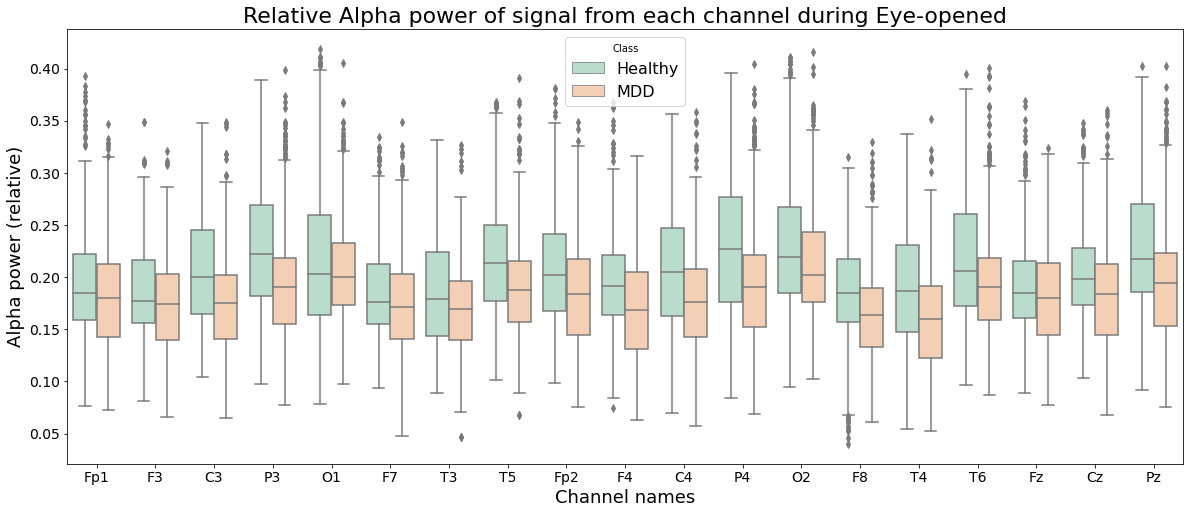

In [ ]:
hue_plot_params = {
    'data': EO_band_power_rel,
    'x': 'channel',
    'y': 'alpha',
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Alpha power (relative)', fontsize=18);
plt.title('Relative Alpha power of signal from each channel during Eye-opened', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('/content/drive/MyDrive/eeg_depression/results/alpha_EO_nostats.jpg')
plt.show()

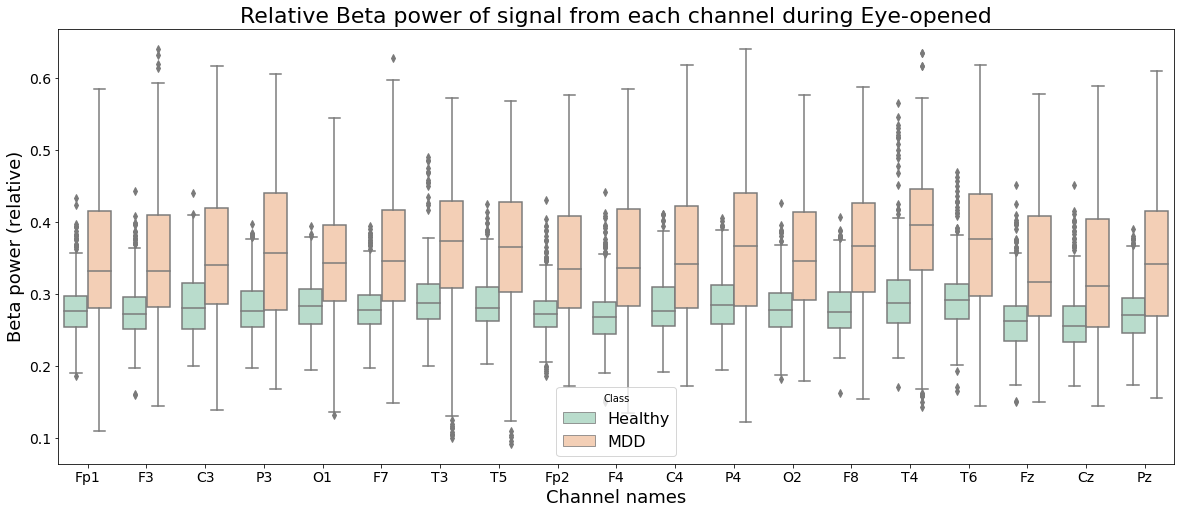

In [ ]:
hue_plot_params = {
    'data': EO_band_power_rel,
    'x': 'channel',
    'y': 'beta',
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Beta power (relative)', fontsize=18);
plt.title('Relative Beta power of signal from each channel during Eye-opened', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)
fig.savefig('/content/drive/MyDrive/eeg_depression/results/beta_EO_nostats.jpg')
plt.show()

## Nonlinear Features

Extracting 3 nonlinear features (Sample entropy, Higuchi Fractal Dimension, Hurst exponent) to be able to capture the complexity of the signals

In [ ]:
feats = ['samp_entropy', 'higuchi_fd', 'hurst_exp']
channels = ['Fp1','F3','C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Fz', 'Cz', 'Pz']

In [ ]:
def get_nonlinear_feats(data, feats):
  n_ch = data.shape[1]
  band_power_arr = np.zeros((data.shape[0], n_ch, len(feats)))
  for i in range(data.shape[0]):
    for ch in range(n_ch):
      band_power_arr[i,ch,:] = extract_features(data[i,ch], band)
  return band_power_arr

In [ ]:
def get_nonlinear_feats_df(data, label, channels, feats, sf=256):
  df = pd.DataFrame(columns=['group', 'channel']+feats, index=range(0, data.shape[0]*data.shape[1]))

  df.loc[:(np.where(label==0)[0][-1]+1)*19, 'group'] = 'Healthy'
  df.loc[(np.where(label==0)[0][-1]+1)*19:, 'group'] = 'MDD'

  for ch_id, ch in enumerate(channels):
    df.loc[ch_id:data.shape[0]*data.shape[1]:len(channels),'channel'] = ch

  extracted_feats = extract_features(data, sf, feats)
  df.loc[:, feats] = np.vstack(np.swapaxes(extracted_feats.reshape(-1,len(feats),19), 1,2))

  return df

In [ ]:
EC_nonlinear_feats = get_nonlinear_feats_df(EC_arr_epoch, EC_labelarr_epoch, channels, feats, 256)
EC_nonlinear_feats = EC_nonlinear_feats.astype({'samp_entropy': 'float64', 'higuchi_fd': 'float64', 'hurst_exp': 'float64'})
EC_nonlinear_feats.to_csv("/content/drive/MyDrive/eeg_depression/EC_nonlinear_feats.csv")

EO_nonlinear_feats = get_nonlinear_feats_df(EO_arr_epoch, EO_labelarr_epoch, channels, feats, 256)
EO_nonlinear_feats = EO_nonlinear_feats.astype({'samp_entropy': 'float64', 'higuchi_fd': 'float64', 'hurst_exp': 'float64'})
EO_nonlinear_feats.to_csv("/content/drive/MyDrive/eeg_depression/EO_nonlinear_feats.csv")

### Plot

In [ ]:
url = f"https://raw.githubusercontent.com/trevismd/statannotations-tutorials/main/Tutorial_1/utils.py"
!wget --no-cache --backups=1 {url}

--2023-03-25 12:26:12--  https://raw.githubusercontent.com/trevismd/statannotations-tutorials/main/Tutorial_1/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2114 (2.1K) [text/plain]
Failed to rename utils.py to utils.py.1: (2) No such file or directory
Saving to: ‘utils.py’

utils.py            100%[===================>]   2.06K  --.-KB/s    in 0s      

2023-03-25 12:26:12 (20.7 MB/s) - ‘utils.py’ saved [2114/2114]



In [ ]:
pairs = [[(ch, 'Healthy'), (ch, 'MDD')] for ch in channels]

#### EC plot

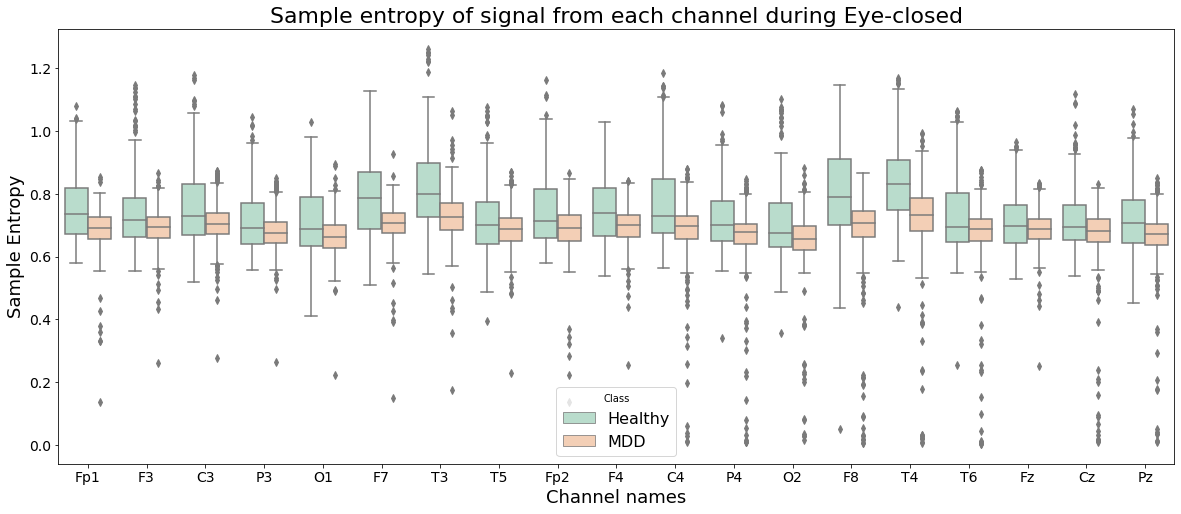

In [ ]:
hue_plot_params = {
    'data': EC_nonlinear_feats,
    'x': 'channel',
    'y': feats[0],
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Sample Entropy', fontsize=18);
plt.title('Sample entropy of signal from each channel during Eye-closed', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)

fig.savefig('/content/drive/MyDrive/eeg_depression/results/sampEn_EC_nostats.jpg')
plt.show()

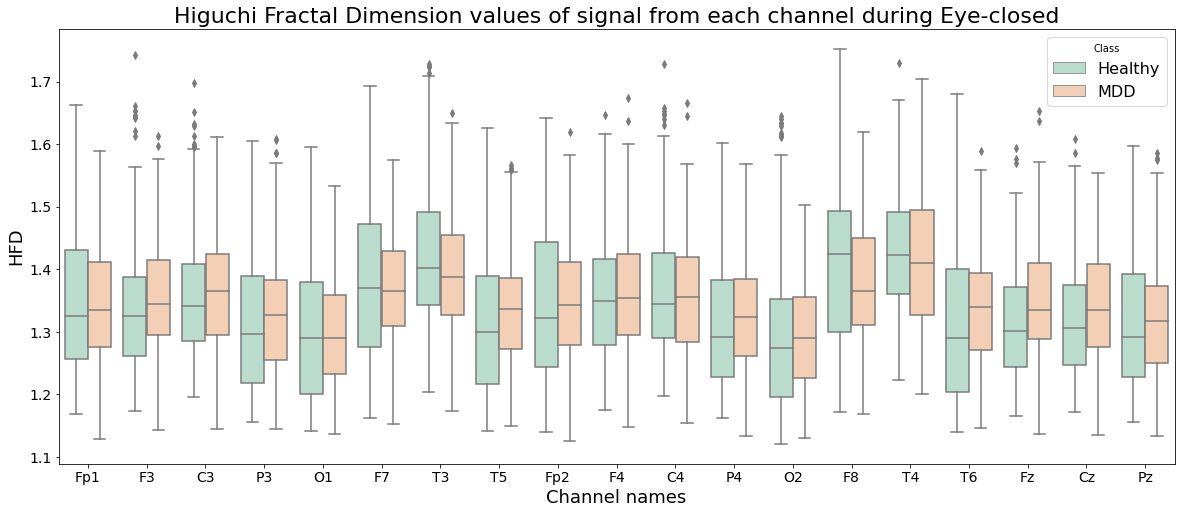

In [ ]:
hue_plot_params = {
    'data': EC_nonlinear_feats,
    'x': 'channel',
    'y': feats[1],
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('HFD', fontsize=18);
plt.title('Higuchi Fractal Dimension values of signal from each channel during Eye-closed', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)

fig.savefig('/content/drive/MyDrive/eeg_depression/results/HFD_EC_nostats.jpg')
plt.show()

<ipython-input-54-96e55d4a042a>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'data': EC_nonlinear_feats[(EC_nonlinear_feats.hurst_exp>=0)][(EC_nonlinear_feats.hurst_exp<=1)],


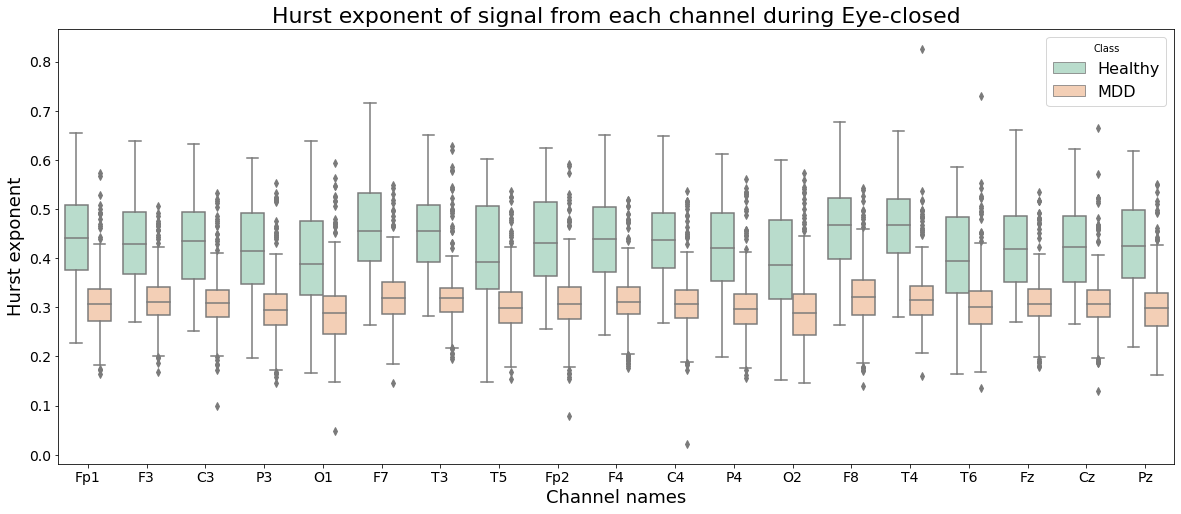

In [ ]:
hue_plot_params = {
    'data': EC_nonlinear_feats[(EC_nonlinear_feats.hurst_exp>=0)][(EC_nonlinear_feats.hurst_exp<=1)],
    'x': 'channel',
    'y': feats[2],
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Hurst exponent', fontsize=18);
plt.title('Hurst exponent of signal from each channel during Eye-closed', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)

fig.savefig('/content/drive/MyDrive/eeg_depression/results/hurst_exp_EC_nostats.jpg')
plt.show()

#### EO plot

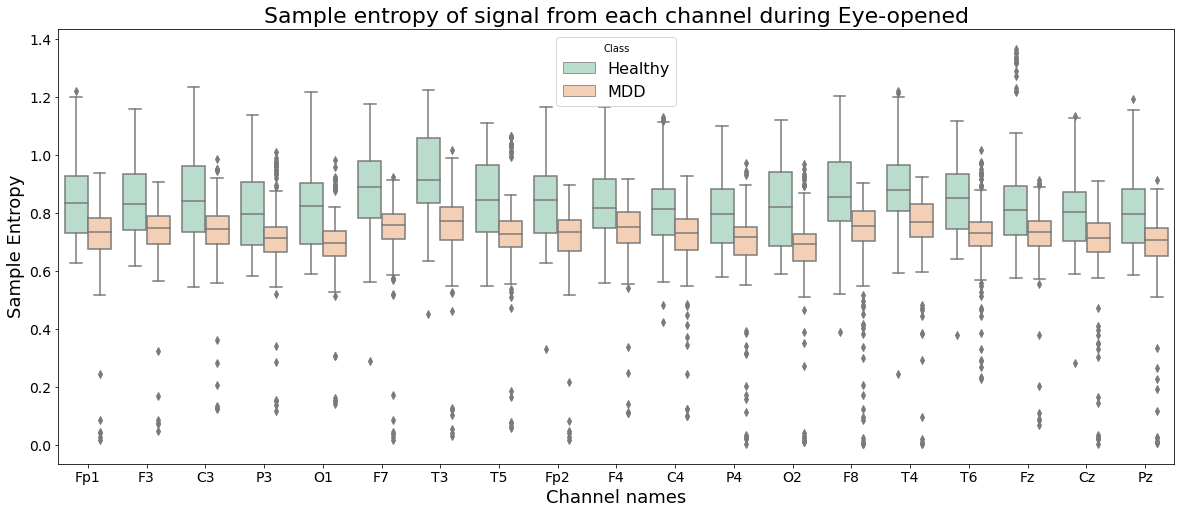

In [ ]:
hue_plot_params = {
    'data': EO_nonlinear_feats,
    'x': 'channel',
    'y': feats[0],
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Sample Entropy', fontsize=18);
plt.title('Sample entropy of signal from each channel during Eye-opened', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)

fig.savefig('/content/drive/MyDrive/eeg_depression/results/sampEn_EO_nostats.jpg')
plt.show()

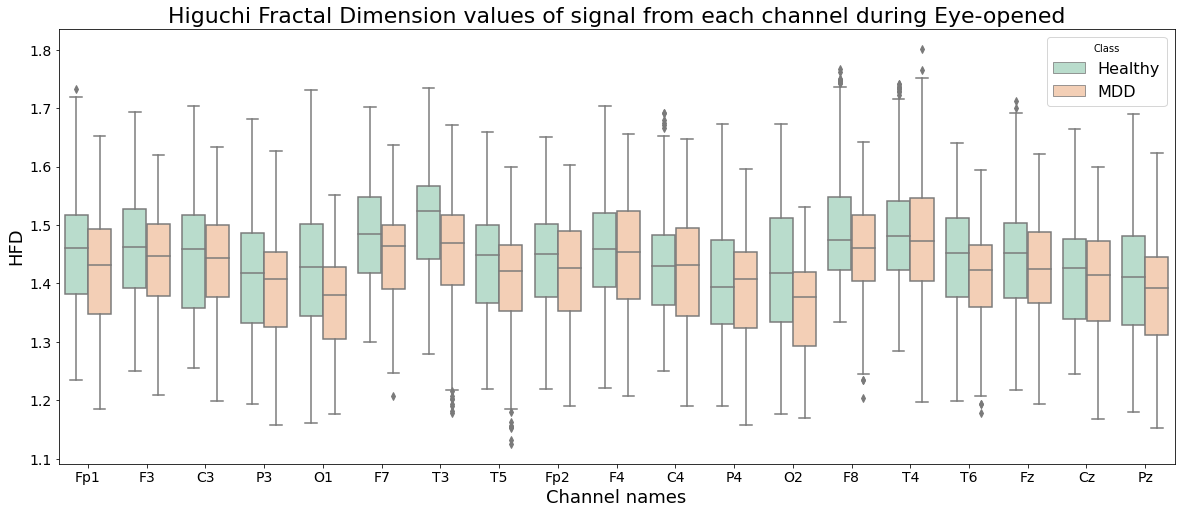

In [ ]:
hue_plot_params = {
    'data': EO_nonlinear_feats,
    'x': 'channel',
    'y': feats[1],
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('HFD', fontsize=18);
plt.title('Higuchi Fractal Dimension values of signal from each channel during Eye-opened', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)

fig.savefig('/content/drive/MyDrive/eeg_depression/results/HFD_EO_nostats.jpg')
plt.show()

<ipython-input-57-01fa35e7ea2b>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  'data': EO_nonlinear_feats[(EO_nonlinear_feats.hurst_exp>=0)][(EO_nonlinear_feats.hurst_exp<=1)],


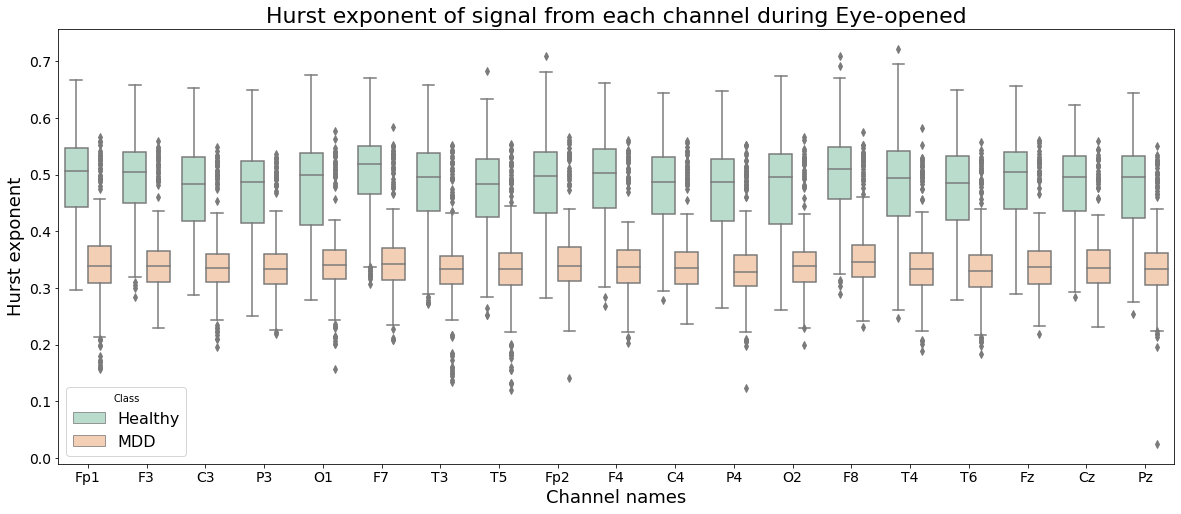

In [ ]:
hue_plot_params = {
    'data': EO_nonlinear_feats[(EO_nonlinear_feats.hurst_exp>=0)][(EO_nonlinear_feats.hurst_exp<=1)],
    'x': 'channel',
    'y': feats[2],
    "hue": "group",
    "palette": "Pastel2"
}

fig, ax = plt.subplots(1,1, figsize=(20,8))
sns.boxplot(**hue_plot_params)

plt.legend(title='Class', fontsize=16)
plt.xlabel('Channel names', fontsize=18);
plt.ylabel('Hurst exponent', fontsize=18);
plt.title('Hurst exponent of signal from each channel during Eye-opened', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=14)

fig.savefig('/content/drive/MyDrive/eeg_depression/results/hurst_exp_EO_nostats.jpg')
plt.show()

## Statistical Analysis

In [ ]:
def get_arr(df, col_used, groupby=None):
  """
    groupby = (group:str, func:list)

  """
  df = df.reset_index()
  label = [0 if df.loc[i,'group'] == 'Healthy' else 1 for i in range(0,len(df),19)]
  Feat = []
  feat = []

  if groupby != None:
    group, func = groupby
    n_group = len(set(df[group]))
    groups = ['trial']
    groups.append(group)
    df_ = df.groupby(groups).aggregate(func).reset_index()

    for i in range(len(df_)):
      feat.append(df_.loc[i,col_used].values)
      if (i+1)%n_group == 0:
        Feat.append(feat)
        feat = []
    arr = np.array(Feat)

  else:
    for i in range(len(df)):
      feat.append(df.loc[i,col_used].values)
      if (i+1)%19 == 0:
        Feat.append(feat)
        feat = []
    arr = np.array(Feat)

  return arr, np.array(label)

In [ ]:
EC_band_power = pd.read_csv("/content/drive/MyDrive/eeg_depression/EC_band_power.csv", index_col=0)
EO_band_power = pd.read_csv("/content/drive/MyDrive/eeg_depression/EO_band_power.csv", index_col=0)

EC_nonlinear_feats = pd.read_csv("/content/drive/MyDrive/eeg_depression/EC_nonlinear_feats.csv", index_col=0)
EO_nonlinear_feats = pd.read_csv("/content/drive/MyDrive/eeg_depression/EO_nonlinear_feats.csv", index_col=0)

In [ ]:
EC_df = EC_band_power.merge(EC_nonlinear_feats[['samp_entropy', 'higuchi_fd', 'hurst_exp']], left_index=True, right_index=True)
EO_df = EO_band_power.merge(EO_nonlinear_feats[['samp_entropy', 'higuchi_fd', 'hurst_exp']], left_index=True, right_index=True)

EC_df.to_csv("/content/drive/MyDrive/eeg_depression/EC_df.csv")
EO_df.to_csv("/content/drive/MyDrive/eeg_depression/EO_df.csv")

In [ ]:
EC_df.head()

,group,channel,delta,theta,alpha,beta,samp_entropy,higuchi_fd,hurst_exp
0,Healthy,Fp1,0.22716,0.17090,0.36406,0.22326,0.67841,1.23356,0.43477
1,Healthy,F3,0.33120,0.19658,0.31664,0.22481,0.65321,1.24540,0.45105
2,Healthy,C3,0.32540,0.17907,0.32178,0.22909,0.65689,1.25442,0.46251
3,Healthy,P3,0.22054,0.12917,0.38179,0.24897,0.62060,1.20146,0.45313
4,Healthy,O1,0.10361,0.08827,0.41519,0.25836,0.62063,1.16327,0.33533


###ANOVA

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [ ]:
# Performing two-way ANOVA delta EC
model = ols('delta ~ C(group)',
			data=EC_band_power_rel).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EC_delta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,2.881175,2.881175,326.299613,4.468688e-64
Residual,1100.0,9.712829,0.008830,NaN,NaN


In [ ]:
# Performing two-way ANOVA theta EC
model = ols('theta ~ C(group)',
			data=EC_band_power_rel).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EC_theta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.039292,0.039292,10.421202,0.001283
Residual,1100.0,4.147380,0.003770,NaN,NaN


In [ ]:
# Performing two-way ANOVA alpha EC
model = ols('alpha ~ C(group)',
			data=EC_band_power_rel).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EC_alpha_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.262007,0.262007,44.727112,3.596670e-11
Residual,1100.0,6.443689,0.005858,NaN,NaN


In [ ]:
# Performing two-way ANOVA beta EC
model = ols('beta ~ C(group)',
			data=EC_band_power_rel).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EC_beta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,2.046381,2.046381,456.452016,5.468807e-85
Residual,1100.0,4.931556,0.004483,NaN,NaN


In [ ]:
# Performing two-way ANOVA delta EO
model = ols('delta ~ C(group)',
			data=EO_band_power_rel).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EO_delta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,3.371174,3.371174,336.478707,4.819173e-66
Residual,1138.0,11.401602,0.010019,NaN,NaN


In [ ]:
# Performing two-way ANOVA theta EO
model = ols('theta ~ C(group)',
			data=EO_band_power_rel).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EO_theta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.021119,0.021119,3.502806,0.061521
Residual,1138.0,6.861316,0.006029,NaN,NaN


In [ ]:
# Performing two-way ANOVA alpha EO
model = ols('alpha ~ C(group)',
			data=EO_band_power_rel).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EO_alpha_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.189478,0.189478,66.774569,8.039075e-16
Residual,1138.0,3.229159,0.002838,NaN,NaN


In [ ]:
# Performing two-way ANOVA beta EO
model = ols('beta ~ C(group)',
			data=EO_band_power_rel).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EO_beta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,1.823567,1.823567,353.887146,5.945270e-69
Residual,1138.0,5.864070,0.005153,NaN,NaN


In [ ]:
# Performing two-way ANOVA SampEn EC
model = ols('samp_entropy ~ C(group)',
			data=EC_df).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EO_beta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,16.991704,16.991704,1533.423177,9.243968e-321
Residual,16452.0,182.302916,0.011081,NaN,NaN


In [ ]:
# Performing two-way ANOVA HFD EC
model = ols('higuchi_fd ~ C(group)',
			data=EC_df).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EO_beta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,0.018504,0.018504,1.731222,0.188273
Residual,16452.0,175.843709,0.010688,NaN,NaN


In [ ]:
# Performing two-way ANOVA Hurst EC
model = ols('hurst_exp ~ C(group)',
			data=EC_df).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EO_beta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,93.389949,93.389949,2767.589896,0.0
Residual,16452.0,555.158640,0.033744,NaN,NaN


In [ ]:
# Performing two-way ANOVA SampEn EO
model = ols('samp_entropy ~ C(group)',
			data=EO_df).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EO_beta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,62.357588,62.357588,4108.971574,0.0
Residual,16908.0,256.595132,0.015176,NaN,NaN


In [ ]:
# Performing two-way ANOVA HFD EO
model = ols('higuchi_fd ~ C(group)',
			data=EO_df).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EO_beta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,3.126018,3.126018,321.249704,3.525296e-71
Residual,16908.0,164.528419,0.009731,NaN,NaN


In [ ]:
# Performing two-way ANOVA Hurst EO
model = ols('hurst_exp ~ C(group)',
			data=EO_df).fit()
result = sm.stats.anova_lm(model, type=2)
pd.DataFrame(result)#.to_csv("/content/drive/MyDrive/eeg_depression/results/EO_beta_ANOVA.csv")

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,111.779561,111.779561,3225.624155,0.0
Residual,16908.0,585.923447,0.034654,NaN,NaN
